In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sb
import torch.nn as nn

# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/HW2/Data/HW2_data/international_matches.csv')
df = pd.DataFrame(data)
df[-10:]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


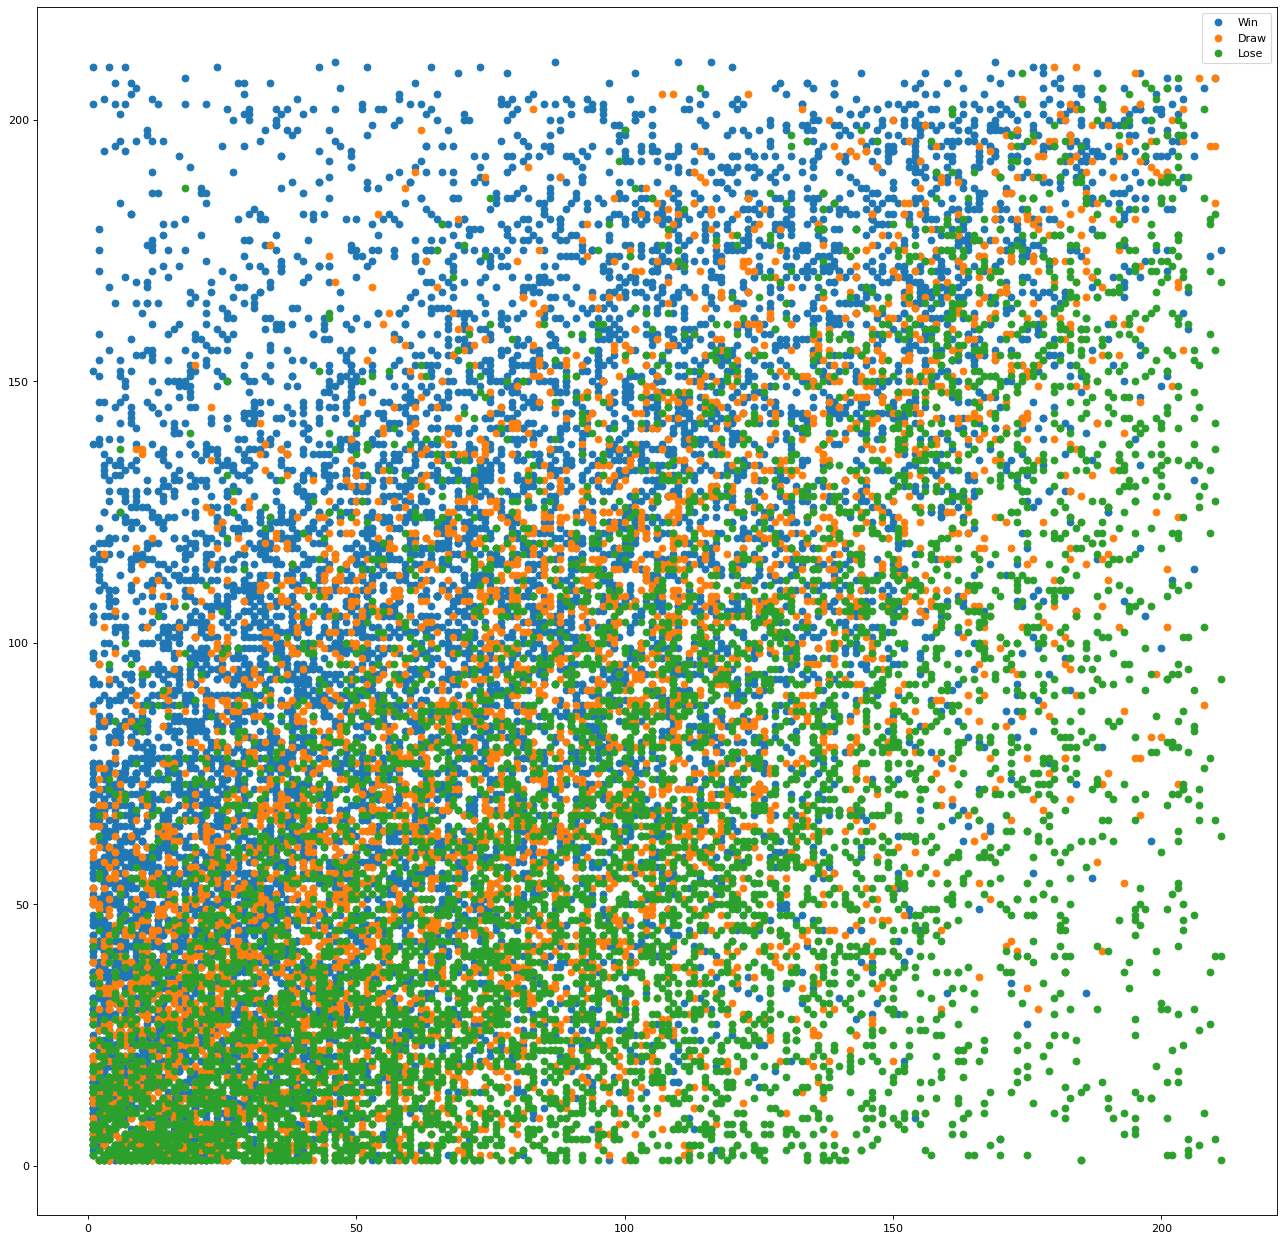

In [ ]:
plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(df.loc[df['home_team_result']=='Win'	]['home_team_fifa_rank'], df.loc[df['home_team_result']=='Win'	]['away_team_fifa_rank'], label ='Win')
plt.scatter(df.loc[df['home_team_result']=='Draw'	]['home_team_fifa_rank'], df.loc[df['home_team_result']=='Draw'	]['away_team_fifa_rank'], label ='Draw')
plt.scatter(df.loc[df['home_team_result']=='Lose'	]['home_team_fifa_rank'], df.loc[df['home_team_result']=='Lose'	]['away_team_fifa_rank'], label ='Lose')
plt.legend()
plt.show()

In [ ]:
ds=df[(df['home_team_total_fifa_points'] > 0) | (df['away_team_total_fifa_points'] >0) ]
ds=ds.reset_index(drop=True)


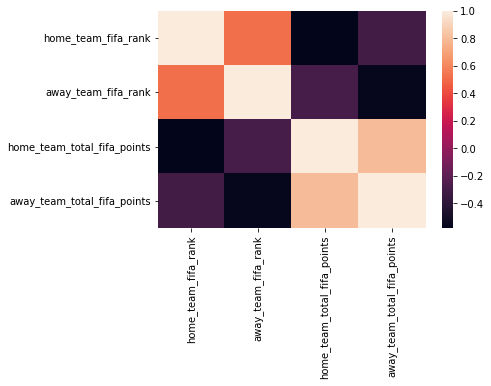

In [ ]:
features = ds[['home_team_fifa_rank','away_team_fifa_rank','home_team_total_fifa_points','away_team_total_fifa_points']]
dataplot=sb.heatmap(features.corr())
temp_features = features.copy()

In [ ]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        sample = ( data, label)
        return sample

features = torch.tensor(temp_features.values).type(torch.float32)
labels = torch.tensor(ds['home_team_result'].replace('Win', 2).replace('Draw', 1).replace('Lose', 0))
DS = MyDataset(features, labels)

In [ ]:
torch.manual_seed(42)
a = list(DS)
b=torch.randperm(len(a))[:int(len(a)*0.75)+1]
c = torch.arange(0,len(a))
d=torch.arange(0,len(a))
d[b] = -1
training_data = MyDataset(DS.features[b], DS.labels[b])
test_data = MyDataset(DS.features[d==c], DS.labels[d==c])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

In [ ]:
model = NeuralNetwork().to(device)
# setting models mode to train mode
model.train()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [ ]:
learning_rate = 1e-3
epochs = 5

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_accuracy = test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 15.855919  [    0/ 7253]
loss: 1.104772  [ 6400/ 7253]
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.059754 

Epoch 2
-------------------------------
loss: 1.105440  [    0/ 7253]
loss: 1.025754  [ 6400/ 7253]
Test Error: 
 Accuracy: 50.4%, Avg loss: 1.087584 

Epoch 3
-------------------------------
loss: 1.091604  [    0/ 7253]
loss: 0.912095  [ 6400/ 7253]
Test Error: 
 Accuracy: 51.7%, Avg loss: 1.126021 

Epoch 4
-------------------------------
loss: 1.212289  [    0/ 7253]
loss: 0.997651  [ 6400/ 7253]
Test Error: 
 Accuracy: 55.4%, Avg loss: 0.979993 

Epoch 5
-------------------------------
loss: 1.019194  [    0/ 7253]
loss: 0.950956  [ 6400/ 7253]
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.027155 

Epoch 6
-------------------------------
loss: 0.943075  [    0/ 7253]
loss: 0.898317  [ 6400/ 7253]
Test Error: 
 Accuracy: 56.2%, Avg loss: 0.966851 

Epoch 7
-------------------------------
loss: 0.983529  [    0/ 7253]
loss: 0.850551  [

In [ ]:
 print(f" Original Model Test Accuracy: {(100*test_accuracy):>0.1f}%")

 Original Model Test Accuracy: 58.2%


In [ ]:
Team_Dict = {'IR Iran': torch.tensor([  20.,1564.61]),
 'England': torch.tensor([   5., 1728.47]),
 'USA': torch.tensor([  16., 1627.48]),
 'Wales': torch.tensor([  19.,1569.82])}

In [ ]:
def predict(X,home_team,away_team):
  print("If "+home_team+" is home_team and "+away_team+" is away_team: ")
  logits = model(X)
   # calculating model predictions by applying a softmax
  probs = nn.Softmax(dim=1)(logits) # finding the probabilities
  if home_team == 'IR Iran':
    print(f"Predicted probability of Iran's victory: {probs[0][2]}")
  else:
    print(f"Predicted probability of Iran's victory: {probs[0][0]} ")
    
  y_pred = probs.argmax(1)
  if y_pred.item()==2:
    print(home_team+' will win\n')
  elif y_pred.item()==1:
     print('Result will be draw\n')
  else:
     print(away_team+' will win\n')

X_England_Iran = torch.tensor([[Team_Dict['England'][0],Team_Dict['IR Iran'][0],Team_Dict['England'][1],Team_Dict['IR Iran'][1]]])
predict(X_England_Iran.to(device),'England','IR Iran')
X_Iran_England = torch.tensor([[Team_Dict['IR Iran'][0],Team_Dict['England'][0],Team_Dict['IR Iran'][1],Team_Dict['England'][1]]])
predict(X_Iran_England.to(device),'IR Iran','England')

X_USA_Iran = torch.tensor([[Team_Dict['USA'][0],Team_Dict['IR Iran'][0],Team_Dict['USA'][1],Team_Dict['IR Iran'][1]]])
predict(X_USA_Iran.to(device),'USA','IR Iran')
X_Iran_USA = torch.tensor([[Team_Dict['IR Iran'][0],Team_Dict['USA'][0],Team_Dict['IR Iran'][1],Team_Dict['USA'][1]]])
predict(X_Iran_USA.to(device),'IR Iran','USA')

X_Wales_Iran = torch.tensor([[Team_Dict['Wales'][0],Team_Dict['IR Iran'][0],Team_Dict['Wales'][1],Team_Dict['IR Iran'][1]]])
predict(X_Wales_Iran.to(device),'Wales','IR Iran')
X_Iran_Wales = torch.tensor([[Team_Dict['IR Iran'][0],Team_Dict['Wales'][0],Team_Dict['IR Iran'][1],Team_Dict['Wales'][1]]])
predict(X_Iran_Wales.to(device),'IR Iran','Wales')

If England is home_team and IR Iran is away_team: 
Predicted probability of Iran's victory: 0.27940693497657776 
England will win

If IR Iran is home_team and England is away_team: 
Predicted probability of Iran's victory: 0.25095340609550476
England will win

If USA is home_team and IR Iran is away_team: 
Predicted probability of Iran's victory: 0.36796900629997253 
USA will win

If IR Iran is home_team and USA is away_team: 
Predicted probability of Iran's victory: 0.33763447403907776
USA will win

If Wales is home_team and IR Iran is away_team: 
Predicted probability of Iran's victory: 0.4312261939048767 
IR Iran will win

If IR Iran is home_team and Wales is away_team: 
Predicted probability of Iran's victory: 0.3935316801071167
Wales will win

